# `Lead Scoring `
### Predicting the scores of lead conversion

An education company named X Education sells online courses to industry professionals. On any given day, many professionals who are interested in the courses land on their website and browse for courses. 

 

The company markets its courses on several websites and search engines like Google. Once these people land on the website, they might browse the courses or fill up a form for the course or watch some videos. When these people fill up a form providing their email address or phone number, they are classified to be a lead. Moreover, the company also gets leads through past referrals. Once these leads are acquired, employees from the sales team start making calls, writing emails, etc. Through this process, some of the leads get converted while most do not. The typical lead conversion rate at X education is around 30%. 

 

Now, although X Education gets a lot of leads, its lead conversion rate is very poor. For example, if, say, they acquire 100 leads in a day, only about 30 of them are converted. To make this process more efficient, the company wishes to identify the most potential leads, also known as ‘Hot Leads’. If they successfully identify this set of leads, the lead conversion rate should go up as the sales team will now be focusing more on communicating with the potential leads rather than making calls to everyone.

#### `Business Objective:`
X Education has appointed you to help them select the most promising leads, i.e. the leads that are most likely to convert into paying customers. The company requires you to build a model wherein you need to assign a lead score to each of the leads such that the customers with higher lead score have a higher conversion chance and the customers with lower lead score have a lower conversion chance. The scores must lie between 0 and 100. The CEO, in particular, has given a ballpark of the target lead conversion rate to be around 80%.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',50)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

import warnings
warnings.filterwarnings('ignore')

## Reading and Inspecting Dataset

In [2]:
#Importing the dataset and having a glance
leads = pd.read_csv('Leads.csv')
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


From the above, we can see that we have some columns which are generated after the interaction with the leads by sales team. 

This is practically useless for the model since we are required to generate a lead score before the first interaction. Hence, such columns will be __dropped__.

In [3]:
#Shape of the dataset
leads_shape = leads.shape
print('Rows:',leads_shape[0])
print('Columns:',leads_shape[1])

Rows: 9240
Columns: 37


In [4]:
#Information of the columns in the dataset
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

- From the above we can see that there seem to be some missing values, let's try to identify these.
- We also seem to have some columns where the data wa populated after entries from sales team's communication with the leads, these have to be dropped before building the model.

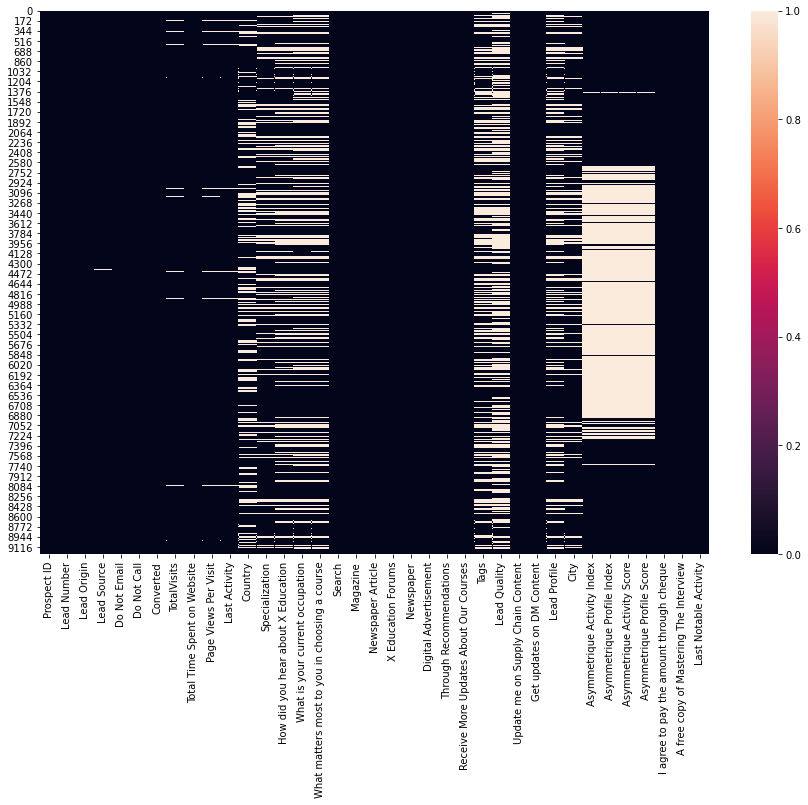

No. of columns with Null values: 17


,count,percent
Lead Quality,4767,51.59
Asymmetrique Activity Index,4218,45.65
Asymmetrique Profile Score,4218,45.65
Asymmetrique Activity Score,4218,45.65
Asymmetrique Profile Index,4218,45.65
Tags,3353,36.29
Lead Profile,2709,29.32
What matters most to you in choosing a course,2709,29.32
What is your current occupation,2690,29.11
Country,2461,26.63


In [5]:
### Null value Analysis

#Distribution of null values in our data
plt.figure(figsize=(15,10))
sns.heatmap(leads.isnull())
plt.show()

#Total number of columns with null values
print('No. of columns with Null values:',leads.isnull().sum()[leads.isnull().sum()>0].shape[0])

#Checking null values
pd.DataFrame({'count':leads.isnull().sum(),'percent':round((leads.isnull().sum()/leads.shape[0])*100, 2)}).sort_values('percent',ascending=False)

- We have 17 columns with missing values.
- Most of the rows seem to have missing values in same columns, this is acting like a pattern in many cases.
- The columns with highest missing values are part of the data generated by the sales team.
- We will consider a threshold of __> 40% missing values__ in columns to drop it.
- The missing values in the rest of the columns will be imputed based on the distribution/categorical counts.

Hence, __Null values treatment__ will be required.

In [6]:
#Checking the unique values of categorical columns and counts for each of the categories
for i in leads.drop('Prospect ID', axis=1).select_dtypes('object'):
    #Printing column name
    print('Column:',i, '(%)')
    print('*'*35)
    
    #Printing percentage of categories
    print(round(leads[i].value_counts(normalize = True, dropna = False),3)*100,'\n\n','No. of unique values:',leads[i].nunique(),'\n','-'*70)

Column: Lead Origin (%)
***********************************
Landing Page Submission    52.9
API                        38.7
Lead Add Form               7.8
Lead Import                 0.6
Quick Add Form              0.0
Name: Lead Origin, dtype: float64 

 No. of unique values: 5 
 ----------------------------------------------------------------------
Column: Lead Source (%)
***********************************
Google               31.0
Direct Traffic       27.5
Olark Chat           19.0
Organic Search       12.5
Reference             5.8
Welingak Website      1.5
Referral Sites        1.4
Facebook              0.6
NaN                   0.4
bing                  0.1
google                0.1
Click2call            0.0
Social Media          0.0
Press_Release         0.0
Live Chat             0.0
WeLearn               0.0
testone               0.0
youtubechannel        0.0
NC_EDM                0.0
Pay per Click Ads     0.0
blog                  0.0
welearnblog_Home      0.0
Name: Lead Sou

Modified                        36.9
Email Opened                    30.6
SMS Sent                        23.5
Page Visited on Website          3.4
Olark Chat Conversation          2.0
Email Link Clicked               1.9
Email Bounced                    0.6
Unsubscribed                     0.5
Unreachable                      0.3
Had a Phone Conversation         0.2
Email Marked Spam                0.0
Form Submitted on Website        0.0
Approached upfront               0.0
Email Received                   0.0
Resubscribed to emails           0.0
View in browser link Clicked     0.0
Name: Last Notable Activity, dtype: float64 

 No. of unique values: 16 
 ----------------------------------------------------------------------


- Some columns have __only 1 category__, such columns can be dropped since they don't help us in making decisions for our dependant variable.
- Some columns with 2 categories also seem to have __categories with extremely low number of observations__, such columns can be dropped too.
- Some columns have __'Select'__ as a category, which means that no option was selected. These can be considered as __NULL values__ and will be marked accordingly.

In [7]:
#Description of numerical columns
leads.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


## Data Cleaning

In [8]:
# Checking the number of unique values available in the identifier variables:
leads[['Prospect ID','Lead Number']].nunique()

Prospect ID    9240
Lead Number    9240
dtype: int64

Both our identifier columns show that there are __no duplicate IDs__ in our dataset.

We will proceed ahead after dropping the above identifier columns.

In [9]:
#Storing variables in a different variable before dropping so as to present the output 'Lead Scores' against the ID
p_id = leads['Prospect ID']
l_num = leads['Lead Number']

# Dropping identifier columns since all values are unique and won't contribute in analysis or modelling
print('Shape before dropping:',leads.shape)
leads.drop(['Prospect ID','Lead Number'], axis=1, inplace=True)
print('Shape after dropping:',leads.shape)

Shape before dropping: (9240, 37)
Shape after dropping: (9240, 35)


We will also have to drop the columns which have just __1 category__ in all the rows.

In [10]:
# Dropping columns with single unique value

print('Shape before dropping:',leads.shape)
leads.drop(leads.nunique()[leads.nunique()==1].index, axis=1, inplace=True)
print('Shape after dropping:',leads.shape)

Shape before dropping: (9240, 35)
Shape after dropping: (9240, 30)


In [11]:
# Dropping columns with 2 categories and one of those having <1% of values

#Creating a list of columns to drop based on our earlier value counts check
cols_2_drop = ['Digital Advertisement','Through Recommendations','Do Not Call',
               'Newspaper Article','Search','Newspaper','X Education Forums']

#Dropping the columns
print('Shape before dropping:',leads.shape)
leads.drop(cols_2_drop, axis=1, inplace=True)
print('Shape after dropping:',leads.shape)

Shape before dropping: (9240, 30)
Shape after dropping: (9240, 23)


In [12]:
#### Replacing 'Select' category with NULL values

#Checking columns which have 'Select' as a category
cols_with_select = [i for i in leads if 'Select' in leads[i].unique()]

#Replacing 'Select' with NULL
leads[cols_with_select] = leads[cols_with_select].replace({'Select':np.nan})

#Validating above changes
for i in leads[cols_with_select]:
    print('Column:',i)
    print('*'*35)
    print(leads[i].value_counts(dropna=False),'\n')

Column: Specialization
***********************************
NaN                                  3380
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Media and Advertising                 203
Travel and Tourism                    203
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: Specialization, dtype: int64 

Column: How did you hear about X Education
***********************************
NaN                      72

In [13]:
# Checking Missing values
null = pd.DataFrame({'count':leads.isnull().sum(),'percent':round((leads.isnull().sum()/leads.shape[0])*100, 2)}).sort_values('percent',ascending=False)
null[null['count']>0]

,count,percent
How did you hear about X Education,7250,78.46
Lead Profile,6855,74.19
Lead Quality,4767,51.59
Asymmetrique Activity Index,4218,45.65
Asymmetrique Profile Index,4218,45.65
Asymmetrique Profile Score,4218,45.65
Asymmetrique Activity Score,4218,45.65
City,3669,39.71
Specialization,3380,36.58
Tags,3353,36.29


- We will drop the column with missing values `> 39%`
- For the rest of the columns, we will try to impute the values

In [14]:
#Dropping column with > 39% missing values
print('Shape before dropping:',leads.shape)
leads.drop(leads.isnull().sum()[leads.isnull().sum() > 0.39*leads.shape[0]].index, axis=1, inplace=True)
print('Shape after dropping:',leads.shape)

Shape before dropping: (9240, 23)
Shape after dropping: (9240, 15)


#### Imputing Missing Values

In [15]:
#Function for getting value counts as percent and count
def value_count(col):
    return round(pd.DataFrame({'Percent':leads[col].value_counts(dropna=False, normalize=True)*100, 'Count':leads[col].value_counts(dropna=False)}),2)

In [16]:
# Checking Missing values
null = pd.DataFrame({'count':leads.isnull().sum(),'percent':round((leads.isnull().sum()/leads.shape[0])*100, 2)}).sort_values('percent',ascending=False)
null[null['count']>0]

,count,percent
Specialization,3380,36.58
Tags,3353,36.29
What matters most to you in choosing a course,2709,29.32
What is your current occupation,2690,29.11
Country,2461,26.63
TotalVisits,137,1.48
Page Views Per Visit,137,1.48
Last Activity,103,1.11
Lead Source,36,0.39


In [17]:
#Checking the value counts of 'Specialization' column
value_count('Specialization')

,Percent,Count
NaN,36.58,3380
Finance Management,10.56,976
Human Resource Management,9.18,848
Marketing Management,9.07,838
Operations Management,5.44,503
Business Administration,4.36,403
IT Projects Management,3.96,366
Supply Chain Management,3.78,349
"Banking, Investment And Insurance",3.66,338
Media and Advertising,2.20,203


- The __percentage of missing values__ is much higher than any of the categories, imputing with __mode__ would create unwanted __Bias__.
- We will impute the missing values with __'Unknown'__
- We will also group the __Management__ and __Business__ specializations in their individual categories.
    - __'Business Administration'__ will be considered under __Management__ category
- Finally, all the categories with `< 3%` observations will be clubbed together as __'Others'__

In [18]:
#Imputing missing values
leads['Specialization'] = leads['Specialization'].fillna('Unknown')

#Joining 'management' specializations
leads['Specialization'] = leads['Specialization'].replace([i for i in leads['Specialization'].unique() if ('Management' in i) or ('Administration' in i)], 'Management')

#Joining 'business' specializations
leads['Specialization'] = leads['Specialization'].replace([i for i in leads['Specialization'].unique() if ('Business' in i) or ('Agribusiness' in i)], 'Business')

#Combining all the categories with with < 3% observations
leads['Specialization'] = leads['Specialization'].replace([i for i in leads['Specialization'].value_counts()[leads['Specialization'].value_counts(normalize=True)<0.03].index], 'Others')

#Validating above changes
value_count('Specialization')

,Percent,Count
Management,50.39,4656
Unknown,36.58,3380
Others,6.04,558
"Banking, Investment And Insurance",3.66,338
Business,3.33,308


In [19]:
#Checking the value counts of 'What matters most to you in choosing a course' column
value_count('What matters most to you in choosing a course')

,Percent,Count
Better Career Prospects,70.65,6528
NaN,29.32,2709
Flexibility & Convenience,0.02,2
Other,0.01,1


- Out of the `4` observations in this category, `2` observations totally constitute just 3 rows, i.e. `~0.03%` of values. Having these categories might cuase the model to overfit.


- The missing values `~30%` can be replaced with the mode, which is __'Better Career Prospects'__.
    - If we impute with  __'Better Career Prospects'__, we get a column with practically just `1` category.

Hence, dropping this column seems to be the only option.

In [20]:
#Dropping the above column
print('Shape before dropping:',leads.shape)
leads.drop('What matters most to you in choosing a course', axis=1, inplace=True)
print('Shape after dropping:',leads.shape)

Shape before dropping: (9240, 15)
Shape after dropping: (9240, 14)


In [21]:
#Checking value counts of 'What is your current occupation' column
value_count('What is your current occupation')

,Percent,Count
Unemployed,60.61,5600
NaN,29.11,2690
Working Professional,7.64,706
Student,2.27,210
Other,0.17,16
Housewife,0.11,10
Businessman,0.09,8


- Imputing with __'Unemployed' (mode)__ category would increase the bias and render this column useless, hence it will not be preferred.
- We won't be dropping the column since we get more than 5% of observations from __Working Professional__ which seems to be significant.
- As per the description provided by the business, this columns provides information for 3 categories: __Unemployed, Employed and Student__, grouping will be done for categories based on these 3 
-  Missing values will be __imputed with 'Unknown'__ since the percentage is huge and imputing with mode will create bias towards the majority category.
- __'Other','Businessman','Working Professional'__ will be replaced as __'Employed'__ 
- __'Housewife'__ will be clubbed into __'Unemployed'__

In [22]:
#Imputing the missing values
leads['What is your current occupation'] = leads['What is your current occupation'].fillna('Unknown')

# Grouping the categories
leads['What is your current occupation'] = leads['What is your current occupation'].replace(['Other','Businessman','Working Professional'], 'Employed')
leads['What is your current occupation'] = leads['What is your current occupation'].replace('Housewife', 'Unemployed')

#Validating the above
value_count('What is your current occupation')

,Percent,Count
Unemployed,60.71,5610
Unknown,29.11,2690
Employed,7.90,730
Student,2.27,210


In [23]:
# Checking unique values in 'Country'
value_count('Country')

,Percent,Count
India,70.26,6492
NaN,26.63,2461
United States,0.75,69
United Arab Emirates,0.57,53
Singapore,0.26,24
Saudi Arabia,0.23,21
United Kingdom,0.16,15
Australia,0.14,13
Qatar,0.11,10
Hong Kong,0.08,7


- Many categories seem to have `< 1%` of observations. We will join them into a single category as __'Others'__
- Imputing the missing values with the __mode__ will create major bias towards __'India'__, hence, it will be imputed with __'Unknown'__

In [24]:
# Performing the above changes
leads['Country'] = leads['Country'].fillna('Unknown').apply(lambda x: 'Others' if x not in ['India','Unknown'] else x)

#Validating above changes
value_count('Country')

,Percent,Count
India,70.26,6492
Unknown,26.63,2461
Others,3.11,287


After __grouping__ and __imputing__, we can see that:
- __India__ creates huge bias in this category.
- __Others__ has very low number of variables, this might create an overfitting model.
- __Unknown__ stands 2nd out of the 3 columns, this category can't provide much of information.


It seems that the best option would be to drop this column.

In [25]:
#Dropping the above column
print('Shape before dropping:',leads.shape)
leads.drop('Country', axis=1, inplace=True)
print('Shape after dropping:',leads.shape)

Shape before dropping: (9240, 14)
Shape after dropping: (9240, 13)


For the numerical columns, we will impute:
- __Mean__, if there are _no outliers_ present.
- __Median__, if there are _outliers_ present.

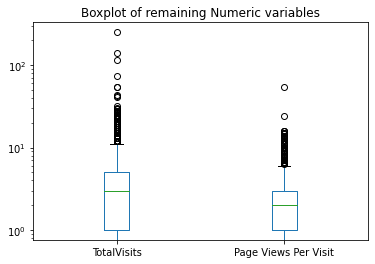

In [26]:
# Checking distribution of Numerical varaibles
leads[['TotalVisits', 'Page Views Per Visit']].plot(kind='box', logy=True) #Using logarithmic y-scale since the scale of values are very different
plt.title('Boxplot of remaining Numeric variables')
plt.show()

There are clearly many outliers in both the variables. Hence, we will impute the columns with their respective __Median__ values.

In [27]:
# Imputing the medians
leads['TotalVisits'] = leads['TotalVisits'].fillna(leads['TotalVisits'].median())
leads['Page Views Per Visit'] = leads['Page Views Per Visit'].fillna(leads['Page Views Per Visit'].median())

In [28]:
#Checking the value counts of 'Lead Source' column
value_count('Lead Source')

,Percent,Count
Google,31.04,2868
Direct Traffic,27.52,2543
Olark Chat,18.99,1755
Organic Search,12.49,1154
Reference,5.78,534
Welingak Website,1.54,142
Referral Sites,1.35,125
Facebook,0.60,55
NaN,0.39,36
bing,0.06,6


- Since the missing values here are just `0.39%`, we will impute these with the mode.
    - This will help us in avoiding the missing of information from other values in those specific rows
- We will combine __'google'__ and __'Google'__
- The categories below `10%` will be clubbed into 1 category __'Others'__

In [29]:
# Imputing missing values
leads['Lead Source'] = leads['Lead Source'].fillna(leads['Lead Source'].mode()[0])

# Converting 'google' to 'Google'
leads['Lead Source'] = leads['Lead Source'].replace('google','Google')

# Clubbing all categories below 5% into 1 category 'Others'
leads['Lead Source'] = leads['Lead Source'].apply(lambda x: 'Others' if x not in ['Google', 'Direct Traffic', 'Olark Chat', 'Organic Search'] else x)

#Validating above changes
value_count('Lead Source')

,Percent,Count
Google,31.48,2909
Direct Traffic,27.52,2543
Olark Chat,18.99,1755
Organic Search,12.49,1154
Others,9.51,879


In [30]:
# Checking Missing values
null = pd.DataFrame({'count':leads.isnull().sum(),'percent':round((leads.isnull().sum()/leads.shape[0])*100, 2)}).sort_values('percent',ascending=False)
null[null['count']>0]

,count,percent
Tags,3353,36.29
Last Activity,103,1.11


Both these categories belong to sales data which will be dropped after visual analysis of our data.
- `Tags` : Since there are many missing values, we will impute with __'Unknown'__
- `Last Activity` : We will impute with it's __mode__ since the missing number of rows are less in number.

In [31]:
# imputing the above
leads['Tags'] = leads['Tags'].fillna('Unknown')
leads['Last Activity'] = leads['Last Activity'].fillna(leads['Last Activity'].mode()[0])

#Checking missing values
null = pd.DataFrame({'count':leads.isnull().sum(),'percent':round((leads.isnull().sum()/leads.shape[0])*100, 2)}).sort_values('percent',ascending=False)
null[null['count']>0]

,count,percent


This concludes our __missing value treatment__. We will proceed ahead with __outlier analysis__.

#### Outlier Analysis

In [32]:
#Function to check if the columns have outliers
def outlier_check(col):
    print(leads[col].describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99, 0.995]))
    sns.boxplot(data=leads,y=col)

count    9240.000000
mean        3.438636
std         4.819024
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
90%         7.000000
95%        10.000000
99%        17.000000
99.5%      20.805000
max       251.000000
Name: TotalVisits, dtype: float64


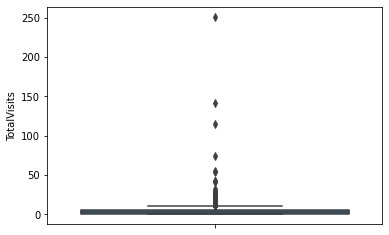

In [33]:
# Checking outliers in 'TotalVisits'
outlier_check('TotalVisits')

- Some values are extremely high which don't seem to be possible under normal conditions.
- Based on the information available, we will __drop the top 0.5 percentile of values.__

In [34]:
#Dropping the top 1 percentile of values
leads = leads[leads['TotalVisits'] <= leads['TotalVisits'].quantile(0.995)]

count    9193.000000
mean      487.005113
std       547.923193
min         0.000000
25%        11.000000
50%       248.000000
75%       935.000000
90%      1379.000000
95%      1561.400000
99%      1840.080000
99.5%    1936.120000
max      2272.000000
Name: Total Time Spent on Website, dtype: float64


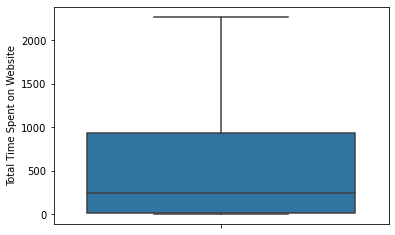

In [35]:
# Checking outliers in 'TotalVisits'
outlier_check('Total Time Spent on Website')

- No outliers can be spotted.

count    9193.000000
mean        2.337670
std         2.048149
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
90%         5.000000
95%         6.000000
99%         9.000000
99.5%      10.000000
max        16.000000
Name: Page Views Per Visit, dtype: float64


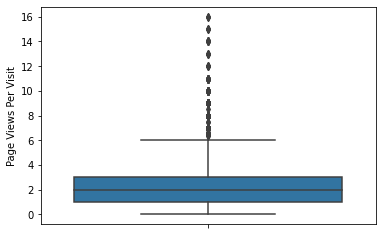

In [36]:
# Checking outliers in 'TotalVisits'
outlier_check('Page Views Per Visit')

- From the boxplot, we can observe some outlier values.
- Since these values are sometimes possible in normal situations, we will not drop any outliers in this case.

#### Checking Datatypes of columns

In [37]:
# Checing the data types
leads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9193 entries, 0 to 9239
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9193 non-null   object 
 1   Lead Source                             9193 non-null   object 
 2   Do Not Email                            9193 non-null   object 
 3   Converted                               9193 non-null   int64  
 4   TotalVisits                             9193 non-null   float64
 5   Total Time Spent on Website             9193 non-null   int64  
 6   Page Views Per Visit                    9193 non-null   float64
 7   Last Activity                           9193 non-null   object 
 8   Specialization                          9193 non-null   object 
 9   What is your current occupation         9193 non-null   object 
 10  Tags                                    9193 non-null   obje

`TotalVisits` and `Page Views Per Visit` might have integer as the apropriate datatype.


We will check the value counts and decide to change datatype accordingly.

In [38]:
#Checking value counts in 'TotalVisits'
value_count('TotalVisits')

,Percent,Count
0.0,23.81,2189
2.0,18.27,1680
3.0,15.70,1443
4.0,12.18,1120
5.0,8.52,783
6.0,5.07,466
1.0,4.30,395
7.0,3.36,309
8.0,2.44,224
9.0,1.78,164


Clearly, the appropriate data type for `TotalVisits` is __integer__.

In [39]:
#Changing the datatype of 'TotalVisits'
leads['TotalVisits'] = leads['TotalVisits'].astype('int64')

In [40]:
#Checking value counts in 'Page Views Per Visits'
value_count('Page Views Per Visit')

,Percent,Count
0.00,23.81,2189
2.00,21.01,1931
3.00,13.01,1196
4.00,9.74,895
1.00,7.08,651
...,...,...
1.31,0.01,1
2.38,0.01,1
1.45,0.01,1
1.54,0.01,1


This variables seems to have many decimal values. This has to be treated as a continue variable and of the ___float___ datatype. No data-type conversion necessary.

#### Percentage of `rows` remaining

In [41]:
print('Percentage of remaining rows after cleaning:',round((leads.shape[0] / leads_shape[0])*100,2),'%')

Percentage of remaining rows after cleaning: 99.49 %


That concludes our data cleaning. We will try to understand our data better with the help of __Exploratory Data Analysis__

## Exploratory Data Analysis

### Univariate Analysis

In [42]:
#Function for univariate Analysis of numerical columns
def uni_num(col, leads=leads):
    print('*'*30,'\n\t',col,'\n','*'*28)
    print(leads[col].describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.97,0.99,0.995]))
    
    #Plots
    plt.figure(figsize=(15,6))
    
    #Boxplot
    plt.subplot(1,2,1)
    sns.boxplot(leads[col], color='cyan')
    plt.title('Boxplot for '+col)
    plt.xlabel(' ')
    
    #Distribution plot
    plt.subplot(1,2,2)
    sns.distplot(leads[col])
    plt.title('Distribution plot for '+col)
    plt.xlabel(' ')
    
    plt.show()
    
#Function for univariate Analysis of categorical columns
def uni_cat(col, rot=0):
    #Printing the value counts of the variable
    print(value_count(col))
    
    #Plotting the countplot
    sns.countplot(x=col,data=leads)
    plt.title('Countplot: '+col, fontsize=15)
    plt.xticks(rotation=rot)
    plt.show()

#### Tagret column - Imbalance Check

   Percent  Count
0    61.48   5652
1    38.52   3541


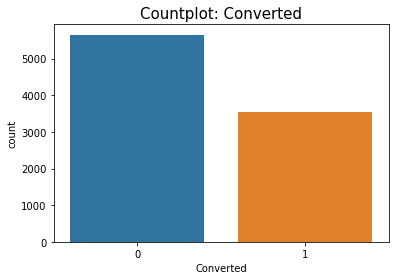

Ratio of data imbalance:  0.627


In [43]:
#Checking the target column
uni_cat('Converted')

#Ratio of data imbalance
print('Ratio of data imbalance: ',round(leads[leads['Converted']==1].shape[0] / leads[leads['Converted']==0].shape[0],3))

- There is a slight data imbalance. 
- Slightly more data on the `1` category would have been better.
- This ratio is still acceptable.

#### Numerical Columns

****************************** 
	 TotalVisits 
 ****************************
count    9193.000000
mean        3.265419
std         3.120763
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
90%         7.000000
95%         9.000000
97%        11.000000
99%        14.000000
99.5%      17.000000
max        20.000000
Name: TotalVisits, dtype: float64


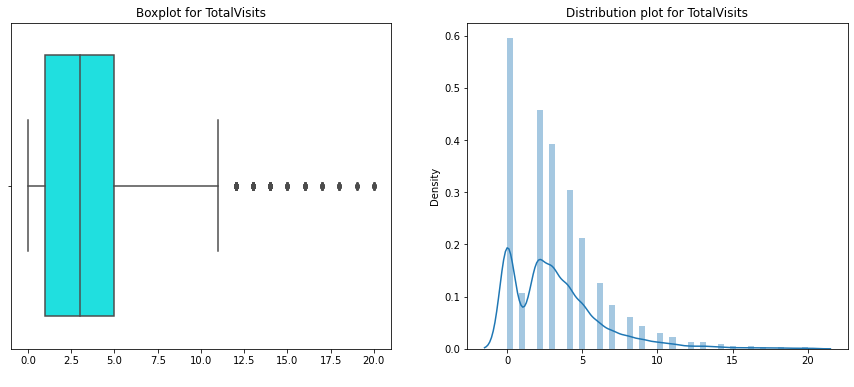

In [44]:
# Checking the 'TotalVisits' column
uni_num('TotalVisits')

****************************** 
	 Page Views Per Visit 
 ****************************
count    9193.000000
mean        2.337670
std         2.048149
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
90%         5.000000
95%         6.000000
97%         7.000000
99%         9.000000
99.5%      10.000000
max        16.000000
Name: Page Views Per Visit, dtype: float64


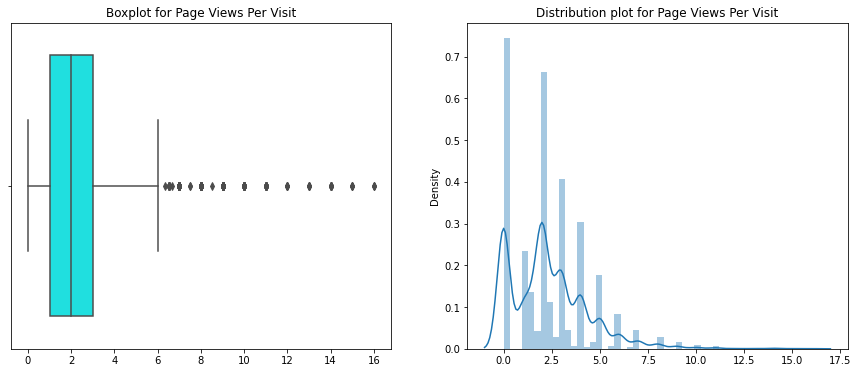

In [45]:
# Checking the 'Page Views Per Visit' column
uni_num('Page Views Per Visit')

****************************** 
	 Total Time Spent on Website 
 ****************************
count    9193.000000
mean      487.005113
std       547.923193
min         0.000000
25%        11.000000
50%       248.000000
75%       935.000000
90%      1379.000000
95%      1561.400000
97%      1660.000000
99%      1840.080000
99.5%    1936.120000
max      2272.000000
Name: Total Time Spent on Website, dtype: float64


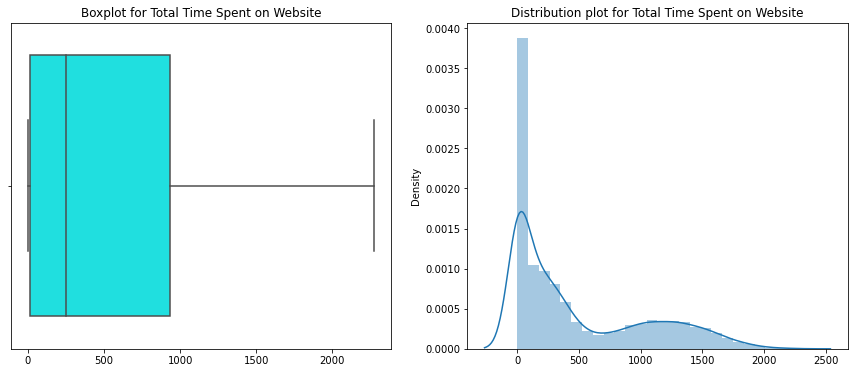

In [46]:
# Checking the 'Total Time Spent on Website' column
uni_num('Total Time Spent on Website')

##### Outlier Analysis

- By dropping some observations of extremely high values (during previously done _Outlier Analysis_), we got rid of some extreme outliers. The remaining values lie in an acceptable range.
- We will consider this as the __final dataset__ and continue.

##### Scaling
- We will prefer normalizing these columns since we will have many categories' dummy variables and all the variables will then be in the same scale.

#### Categorical Columns

                         Percent  Count
Landing Page Submission    52.76   4850
API                        38.83   3570
Lead Add Form               7.80    717
Lead Import                 0.60     55
Quick Add Form              0.01      1


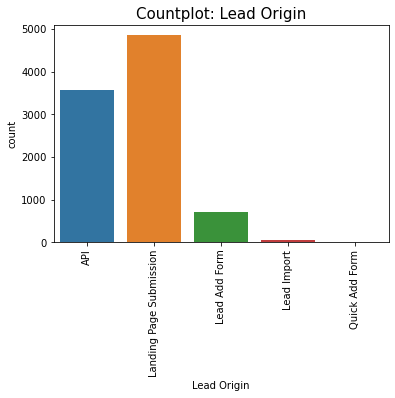

In [47]:
# Checking 'Lead Origin' Column
uni_cat('Lead Origin', rot=90)

- The category __'Quick Add form'__ has just 1 observation, joining this with __'Lead Import'__ would generate wrong interpretation for that row by the model.
    - __Dropping this category__ is the best option, since a loss of 1 row is extremely affordable.

                         Percent  Count
Landing Page Submission    52.76   4850
API                        38.84   3570
Lead Add Form               7.80    717
Lead Import                 0.60     55


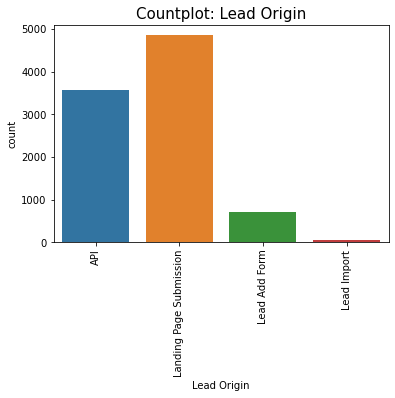

In [48]:
#Dropping the category
leads = leads[leads['Lead Origin']!='Quick Add Form']

#Validating the above
uni_cat('Lead Origin', rot=90)

                Percent  Count
Google            31.52   2897
Direct Traffic    27.49   2527
Olark Chat        19.08   1754
Organic Search    12.38   1138
Others             9.53    876


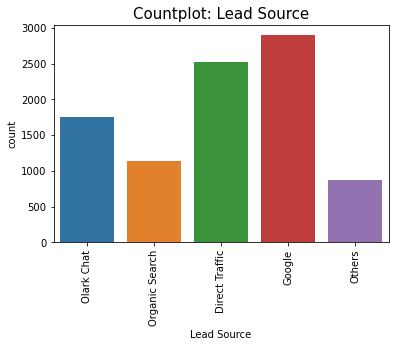

In [49]:
# Checking 'Lead Source' column
uni_cat('Lead Source', rot=90)

- Most of our data seems to come from __Google__

     Percent  Count
No     92.13   8469
Yes     7.87    723


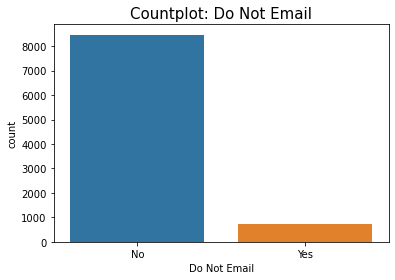

In [50]:
# Checking for 'Do Not Email' column
uni_cat('Do Not Email')

- The imbalance seems to be really huge
- There's a good chance that this variable will be insignificant for our model.
- The decision of dropping this variable will be taken based on it's __p-value and VIF-value__ while model building.

                              Percent  Count
Email Opened                    38.36   3526
SMS Sent                        29.78   2737
Olark Chat Conversation         10.57    972
Page Visited on Website          6.72    618
Converted to Lead                4.66    428
Email Bounced                    3.54    325
Email Link Clicked               2.89    266
Form Submitted on Website        1.26    116
Unreachable                      1.01     93
Unsubscribed                     0.66     61
Had a Phone Conversation         0.33     30
Approached upfront               0.10      9
View in browser link Clicked     0.05      5
Email Received                   0.02      2
Email Marked Spam                0.02      2
Visited Booth in Tradeshow       0.01      1
Resubscribed to emails           0.01      1


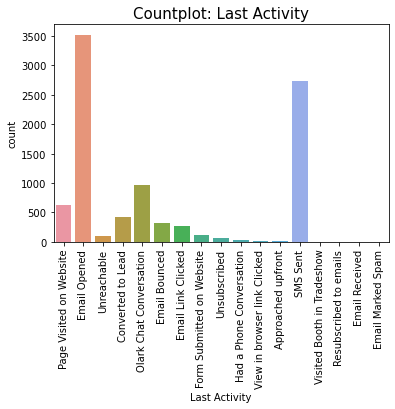

In [51]:
# Checking for 'Last Activity' column
uni_cat('Last Activity', rot=90)

- The highest number of observations is seen in __Email Opened__ followed by __SMS Sent__

            Percent  Count
Unemployed    60.65   5575
Unknown       29.16   2680
Employed       7.91    727
Student        2.28    210


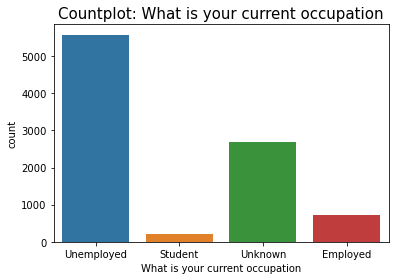

In [52]:
# Checking for 'What is your current occupation' column
uni_cat('What is your current occupation')

- A huge distribution seems to come from __Unemployed__ category

     Percent  Count
No     68.86   6330
Yes    31.14   2862


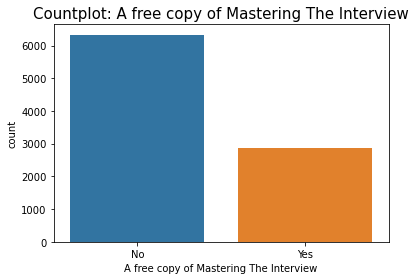

In [53]:
# Checking for 'A free copy of Mastering The Interview' column
uni_cat('A free copy of Mastering The Interview')

- Most leads don't want the free copy as per the data.

                                   Percent  Count
Management                           50.34   4627
Unknown                              36.68   3372
Others                                6.02    553
Banking, Investment And Insurance     3.64    335
Business                              3.32    305


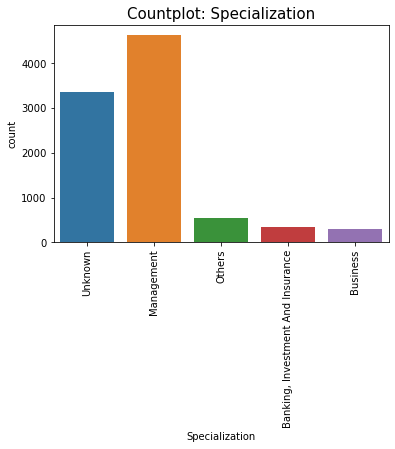

In [54]:
# Checking for 'Specialization' column
uni_cat('Specialization', rot=90)

- We have highest category in __Management__ specialized domains

                              Percent  Count
Modified                        36.95   3396
Email Opened                    30.61   2814
SMS Sent                        23.57   2167
Page Visited on Website          3.27    301
Olark Chat Conversation          1.98    182
Email Link Clicked               1.87    172
Email Bounced                    0.65     60
Unsubscribed                     0.51     47
Unreachable                      0.35     32
Had a Phone Conversation         0.15     14
Email Marked Spam                0.02      2
Form Submitted on Website        0.01      1
Approached upfront               0.01      1
Email Received                   0.01      1
Resubscribed to emails           0.01      1
View in browser link Clicked     0.01      1


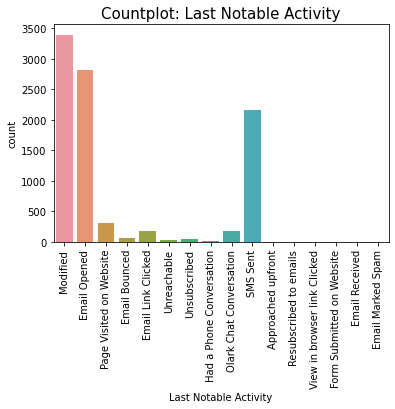

In [55]:
# Checking for 'Last Notable Activity' column
uni_cat('Last Notable Activity', rot=90)

- The distribution here seems to be similar as that of `Last Activity` except __Modified__ category.

                                                   Percent  Count
Unknown                                              36.30   3337
Will revert after reading the email                  22.45   2064
Ringing                                              13.00   1195
Interested in other courses                           5.55    510
Already a student                                     5.06    465
Closed by Horizzon                                    3.83    352
switched off                                          2.61    240
Busy                                                  2.02    186
Lost to EINS                                          1.89    174
Not doing further education                           1.51    139
Interested  in full time MBA                          1.27    117
Graduation in progress                                1.21    111
invalid number                                        0.90     83
Diploma holder (Not Eligible)                         0.69     63
wrong numb

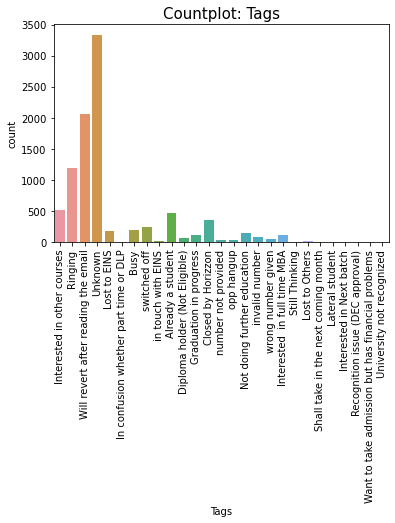

In [56]:
# Checking for 'Tags' column
uni_cat('Tags', rot=90)

- Most of the data after __'Unknown'__ lies in __"Will revert after reading the email'__

    Percent  Count
0     23.81   2189
2     18.28   1680
3     15.69   1442
4     12.18   1120
5      8.52    783
6      5.07    466
1      4.30    395
7      3.36    309
8      2.44    224
9      1.78    164
10     1.24    114
11     0.94     86
13     0.52     48
12     0.49     45
14     0.39     36
16     0.23     21
15     0.20     18
17     0.17     16
18     0.16     15
20     0.13     12
19     0.10      9


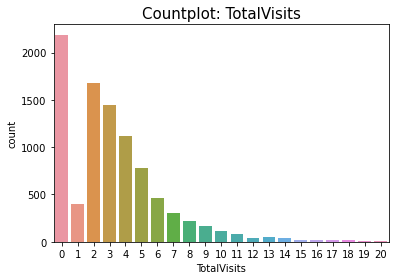

In [57]:
# Checking for 'TotalVisits' column
uni_cat('TotalVisits')

- There seems to be very less leads who have visited the page __just once__
- Highest distribution of leads seem to have __No visits__

### Bivariate Analysis

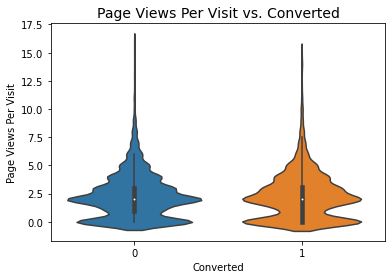

In [58]:
# Page Views Per Visit vs. Converted
sns.violinplot(x='Converted', y='Page Views Per Visit', data=leads)
plt.title('Page Views Per Visit vs. Converted', fontsize=14)
plt.show()

- The distribution for both the `Converted` values can be seen high at __0__ and __2__.
- It can also be observed that 2 page views has slightly lower distribution in __converted leads__ than in __non-converted leads.__

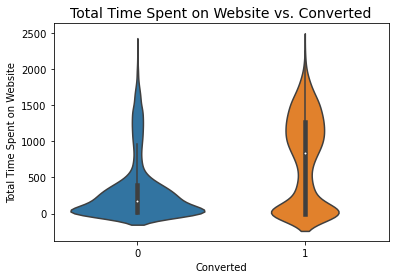

In [59]:
# Page Views Per Visit vs. Converted
sns.violinplot(x='Converted', y='Total Time Spent on Website', data=leads)
plt.title('Total Time Spent on Website vs. Converted', fontsize=14)
plt.show()

- Most of the __non-converted leads__ have 0 time spent on the website
- The distribution at 0 is much more higher for __non-converted leads__ than __converted leads__.

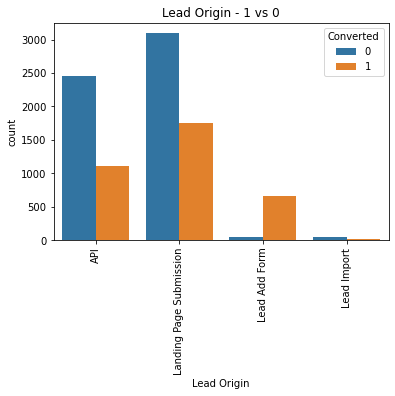

In [60]:
#Lead Origin - 1 vs 0
sns.countplot(x='Lead Origin', data=leads, hue='Converted')
plt.xticks(rotation=90)
plt.title('Lead Origin - 1 vs 0')
plt.show()

- The __non-converted leads__ have much higher observations in `API` and `Landing Page Submission` than __converted leads__.
- Although `Lead Add Form` seems to have higher __converted leads__.

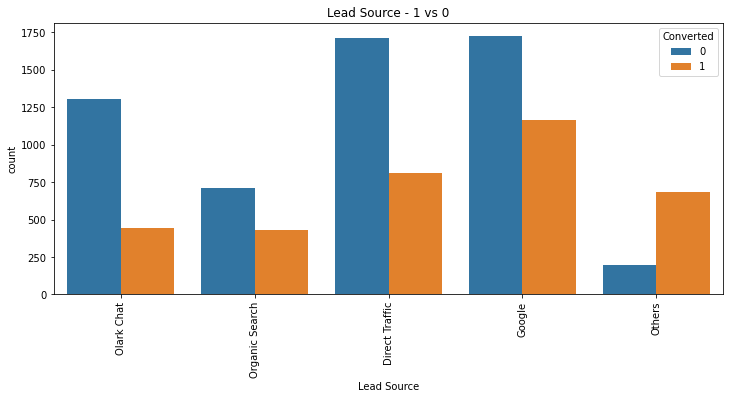

In [61]:
#Lead Source - 1 vs 0
plt.figure(figsize=(12,5))
sns.countplot(x='Lead Source', data=leads, hue='Converted')
plt.xticks(rotation=90)
plt.title('Lead Source - 1 vs 0')
plt.show()

- `Others` seems to create many __converted leads__.
- Most of our __non-converted leads__ belong to:
    - `Olark Chat` (highest)
    - `Organic Search`
    - `Direct Traffic`
    - `Google`

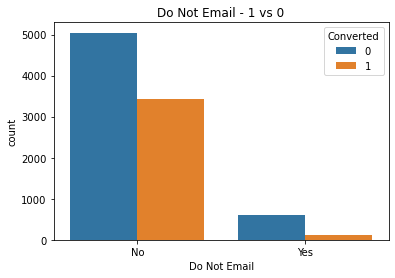

In [62]:
#Do Not Email - 1 vs 0
sns.countplot(x='Do Not Email', data=leads, hue='Converted')
plt.title('Do Not Email - 1 vs 0')
plt.show()

- In both the cases the distribution seems to be similar in terms of __conversion of leads__.

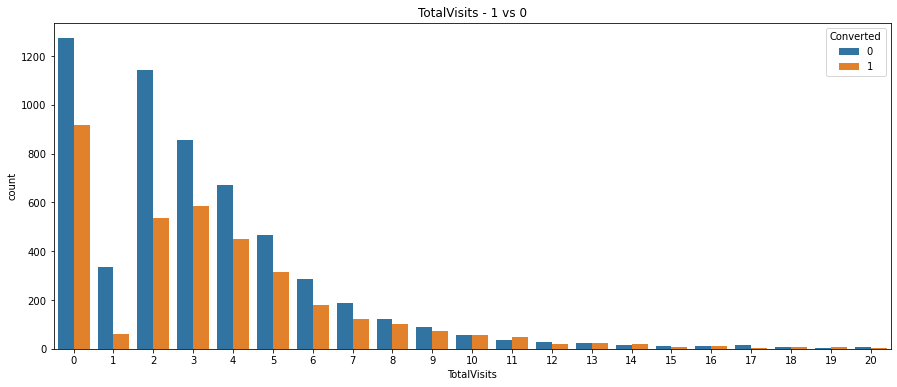

In [63]:
#TotalVisits - 1 vs 0
plt.figure(figsize=(15,6))
sns.countplot(x='TotalVisits', data=leads, hue='Converted')
plt.title('TotalVisits - 1 vs 0')
plt.show()

- The ratio of __conversion__ seems to be almost similar in all __`TotalVisits`__  below `9` values except `1` and `2`, it seems that no. of observations of __non-converted leads__ are much higher than __converted leads__.
- A slight increase can be seen in __converted leads__ as the count of __`TotalVisits`__ increases.

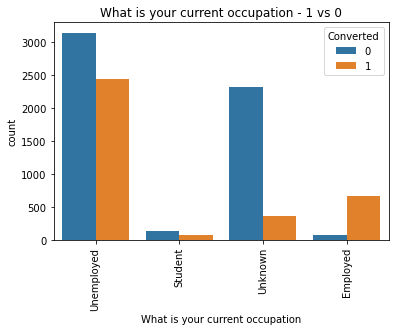

In [64]:
#What is your current occupation - 1 vs 0
sns.countplot(x='What is your current occupation', data=leads, hue='Converted')
plt.title('What is your current occupation - 1 vs 0')
plt.xticks(rotation=90)
plt.show()

- In the case where the current occupation is `Unknown` there seems to be extremely high observations of __non-converted leads__ than __converted leads__.
- `Employed` seems to be a pretty significant factor for identifying __converted leads__
- `Unemployed` category has a ratio of __non-converted leads__ higher than __converted leads__ by a small fraction.

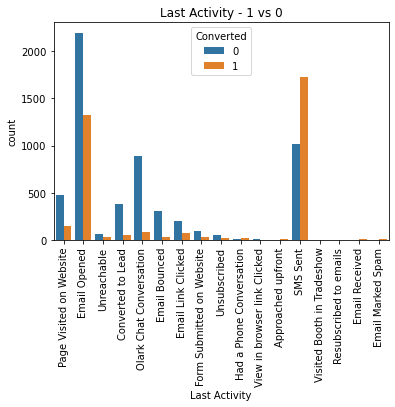

In [65]:
#Last Activity - 1 vs 0
sns.countplot(x='Last Activity', data=leads, hue='Converted')
plt.title('Last Activity - 1 vs 0')
plt.xticks(rotation=90)
plt.show()

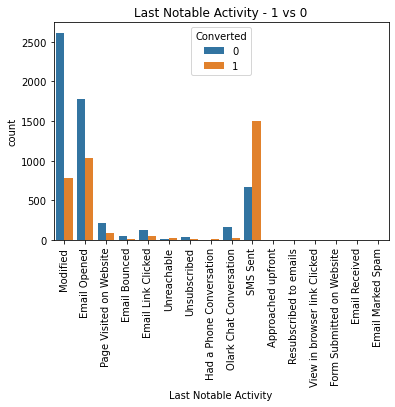

In [66]:
#Last Activity - 1 vs 0
sns.countplot(x='Last Notable Activity', data=leads, hue='Converted')
plt.title('Last Notable Activity - 1 vs 0')
plt.xticks(rotation=90)
plt.show()

- __SMS Sent__ seems to be a major factor for determining whether the lead will be __converted or not__.

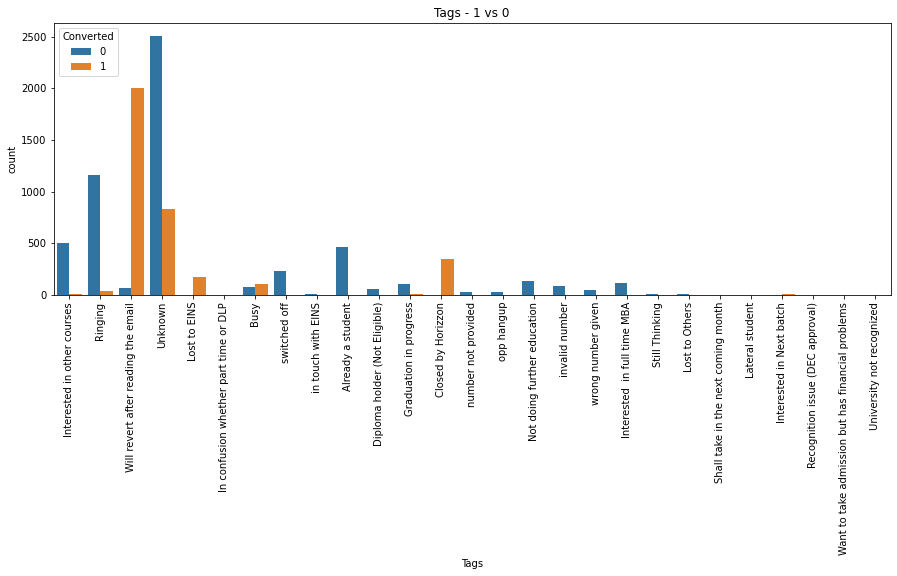

In [67]:
#Tags - 1 vs 0
plt.figure(figsize=(15,5))
sns.countplot(x='Tags', data=leads, hue='Converted')
plt.title('Tags - 1 vs 0')
plt.xticks(rotation=90)
plt.show()

- __Will revert after reading the email__ seems to be a good indicator for __leads to be converted__

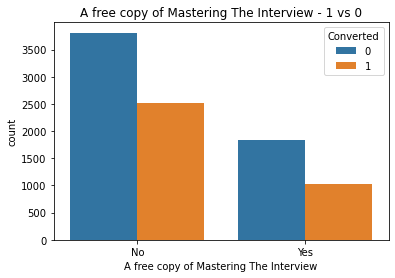

In [68]:
#A free copy of Mastering The Interview - 1 vs 0
sns.countplot(x='A free copy of Mastering The Interview', data=leads, hue='Converted')
plt.title('A free copy of Mastering The Interview - 1 vs 0')
plt.show()

- The __conversion ratio__ in both the cases seems to be same irrespective of getting the free copy.

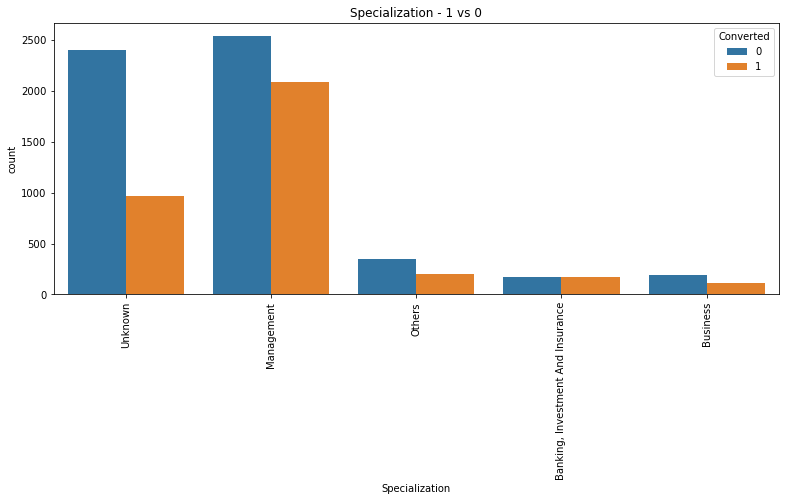

In [69]:
#Specialization - 1 vs 0
plt.figure(figsize=(13,5))
sns.countplot(x='Specialization', data=leads, hue='Converted')
plt.title('Specialization - 1 vs 0')
plt.xticks(rotation=90)
plt.show()

- The ratios of all __Management, Business & Others__ is same with slightly higher __non-converted leads__
- __BFSI__ sector seems have almost equal numbers

### Multivariate Analysis

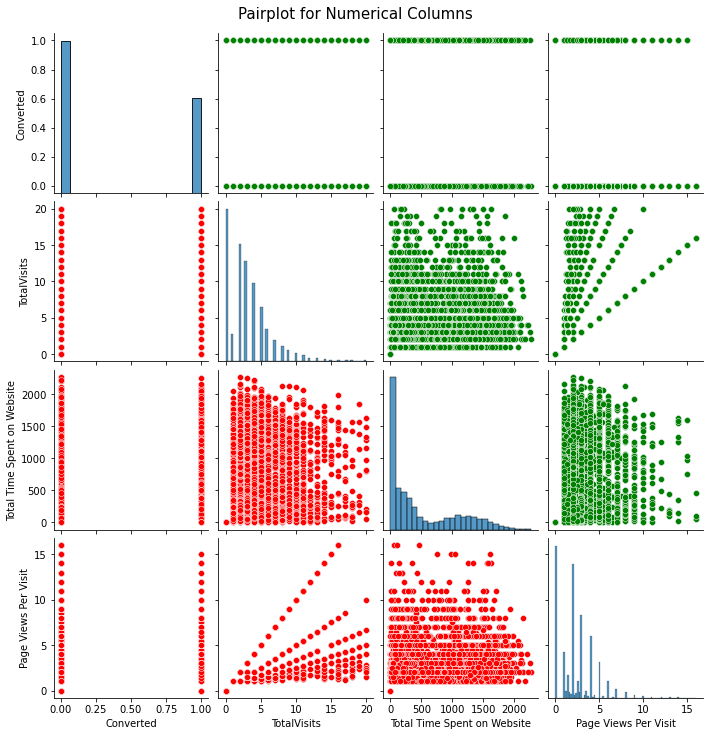

In [70]:
# Pairplot
pairplot = sns.pairplot(leads)
pairplot.map_upper(sns.scatterplot,color='green')
pairplot.map_lower(sns.scatterplot,color='red')
plt.suptitle('Pairplot for Numerical Columns', fontsize=15, y=1.02)
plt.show()

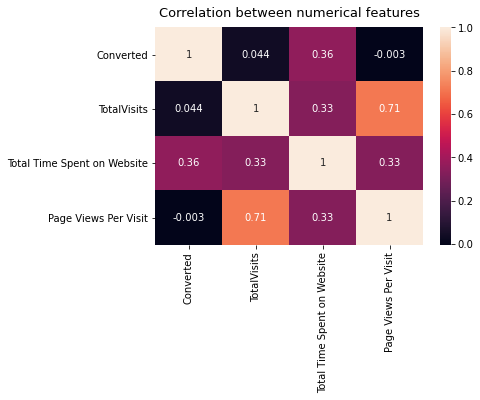

In [71]:
sns.heatmap(leads.corr(), annot=True)
plt.title('Correlation between numerical features', fontsize=13, y=1.02)
plt.show()

All the features seem to have acceptable correlation values and multicolllinearity, except:
- __`TotalVisits`__
- __`Page Views Per Visit`__.


We will take a decision of which of the above columns to drop based on the __p value__ and __VIF value__ during model building.

## Data Preparation

In [72]:
# Dropping the columns populated by 'Sales Team'
print('Shape before dropping:',leads.shape)
leads.drop(['Last Activity','Tags','Last Notable Activity'], axis=1, inplace=True)
print('Shape after dropping:',leads.shape)

Shape before dropping: (9192, 13)
Shape after dropping: (9192, 10)


In [73]:
#Converting binary categorical variables to [0,1] values
leads[['Do Not Email','A free copy of Mastering The Interview']] = leads[['Do Not Email','A free copy of Mastering The Interview']].replace({'No':0,'Yes':1})

In [74]:
#List of columns to be dummified
cols_to_dummy = leads.select_dtypes('object').columns.tolist()

#Creating dummy columns
dummies = pd.get_dummies(leads.select_dtypes('object'), drop_first=True)

#Adding dummy columns to main dataframe 'leads'
leads[dummies.columns] = dummies

#Dropping original columns
leads.drop(cols_to_dummy, axis=1, inplace=True)

#Checking the dataframe
print(leads.shape)
leads.head()

(9192, 20)


,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Others,Specialization_Business,Specialization_Management,Specialization_Others,Specialization_Unknown,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown
0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
1,0,0,5,674,2.5,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
2,0,1,2,1532,2.0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0
3,0,0,1,305,1.0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0,1,2,1428,1.0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0


In [75]:
#Dividing into dependant(Y) and independant(X) datasets
y = leads['Converted']
X = leads.drop('Converted', axis=1)

#Dividing into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=20)

#Normalizing numerical columns
scaler = MinMaxScaler()

#Fitting and transforming on X_train column
X_train[['Total Time Spent on Website','Page Views Per Visit','TotalVisits']] = scaler.fit_transform(X_train[['Total Time Spent on Website','Page Views Per Visit','TotalVisits']])

#Transforming on X_test column
X_test[['Total Time Spent on Website','Page Views Per Visit','TotalVisits']] = scaler.transform(X_test[['Total Time Spent on Website','Page Views Per Visit','TotalVisits']])

#Validating the above
print('Shapes of datasets:\n'+'*'*20)
print('X_train:',X_train.shape,'\nX test:',X_test.shape,'\ny train:',y_train.shape,'\ny test:',y_test.shape)
X_train.head()

Shapes of datasets:
********************
X_train: (6434, 19) 
X test: (2758, 19) 
y train: (6434,) 
y test: (2758,)


,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Others,Specialization_Business,Specialization_Management,Specialization_Others,Specialization_Unknown,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown
2736,0,0.1,0.000880,0.125,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
5577,0,0.0,0.000000,0.000,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
6904,0,0.0,0.000000,0.000,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
3585,0,0.0,0.000000,0.000,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
7044,0,0.2,0.104313,0.250,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1


## Model Building

In [76]:
#Function for checking VIF
def vif_check(X_train):
    vif = pd.DataFrame()
    vif['VIF'] = [VIF(X_train.drop('const',axis=1).values,i) for i in range(len(X_train.drop('const',axis=1).columns))]
    vif['features'] = X_train.drop('const',axis=1).columns

    return vif.sort_values('VIF', ascending=False).reset_index(drop=True)

In [77]:
#RFE with 15 columns on X_train | Using LogisticRegression from SK-learn since it has better compatibility with RFE
model = LogisticRegression()
rfe = RFE(model, 15)
rfe.fit(X_train, y_train)

#RFE columns - support and ranking
pd.DataFrame({'Features':X_train.columns, 'Support':rfe.support_, 'Rank':rfe.ranking_}).sort_values(by='Rank').head(20)

,Features,Support,Rank
0,Do Not Email,True,1
16,What is your current occupation_Student,True,1
15,Specialization_Unknown,True,1
11,Lead Source_Others,True,1
10,Lead Source_Organic Search,True,1
17,What is your current occupation_Unemployed,True,1
8,Lead Source_Google,True,1
9,Lead Source_Olark Chat,True,1
6,Lead Origin_Lead Add Form,True,1
5,Lead Origin_Landing Page Submission,True,1


In [78]:
#Adding constant to the data for statsmodels library
X_train_sm = sm.add_constant(X_train[X_train.columns[rfe.support_]])

#Building the model
model = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6434
Model:                            GLM   Df Residuals:                     6418
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2853.7
Date:                Sun, 16 May 2021   Deviance:                       5707.5
Time:                        16:12:37   Pearson chi2:                 8.00e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          0.8478      0.221      3.841      0.000       0.415       1.280
Do Not Email                                  -1.3388      0.161     -8.314      0.000      -1.654      -1.023
TotalVisits                                    0.8095      0.297      2.722      0.006       0.227       1.392
Total Time Spent on Website                    4.5418      0.163     27.839      0.000       4.222       4.862
Page Views Per Visit                          -0.7453      0.399     -1.866      0.062      -1.528       0.037
Lead Origin_Landing Page Submission           -0.6664      0.128     -5.189      0.000      -0.918      -0.415
Lead Origin_Lead Add Form                      3.9309      0.308     12.766      0.000       3.327       4.534
Lead Origin_Lead Import                       -0.2883      0.508     -0.568      0.570      -1.284       0.707
Lead Source_Google                             0.3118      0.092      3.401      0.001       0.132       0.491
Lead Source_Olark Chat                         1.3431      0.147      9.158      0.000       1.056       1.631
Lead Source_Organic Search                     0.3378      0.120      2.814      0.005       0.103       0.573
Lead Source_Others                             0.1439      0.271      0.530      0.596      -0.388       0.676
Specialization_Unknown                        -0.9471      0.119     -7.977      0.000      -1.180      -0.714
What is your current occupation_Student       -2.2972      0.267     -8.607      0.000      -2.820      -1.774
What is your current occupation_Unemployed    -2.0772      0.169    -12.319      0.000      -2.408      -1.747
What is your current occupation_Unknown       -3.3337      0.182    -18.330      0.000      -3.690      -2.977
==============================================================================================================
"""

In [79]:
#Dropping 'Lead Source_Others' due to high P-Value
X_train_sm.drop('Lead Source_Others', axis=1, inplace=True)

#Building the model
model = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6434
Model:                            GLM   Df Residuals:                     6419
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2853.9
Date:                Sun, 16 May 2021   Deviance:                       5707.7
Time:                        16:12:37   Pearson chi2:                 7.99e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          0.8621      0.219      3.935      0.000       0.433       1.292
Do Not Email                                  -1.3437      0.161     -8.347      0.000      -1.659      -1.028
TotalVisits                                    0.8134      0.297      2.735      0.006       0.230       1.396
Total Time Spent on Website                    4.5399      0.163     27.838      0.000       4.220       4.859
Page Views Per Visit                          -0.7245      0.397     -1.823      0.068      -1.503       0.054
Lead Origin_Landing Page Submission           -0.6766      0.127     -5.330      0.000      -0.925      -0.428
Lead Origin_Lead Add Form                      4.0472      0.218     18.587      0.000       3.620       4.474
Lead Origin_Lead Import                       -0.1632      0.450     -0.363      0.717      -1.045       0.718
Lead Source_Google                             0.2985      0.088      3.386      0.001       0.126       0.471
Lead Source_Olark Chat                         1.3276      0.144      9.241      0.000       1.046       1.609
Lead Source_Organic Search                     0.3239      0.117      2.766      0.006       0.094       0.553
Specialization_Unknown                        -0.9455      0.119     -7.966      0.000      -1.178      -0.713
What is your current occupation_Student       -2.2993      0.267     -8.616      0.000      -2.822      -1.776
What is your current occupation_Unemployed    -2.0775      0.169    -12.324      0.000      -2.408      -1.747
What is your current occupation_Unknown       -3.3337      0.182    -18.333      0.000      -3.690      -2.977
==============================================================================================================
"""

In [80]:
#Dropping 'Lead Origin_Lead Import' due to high P-Value
X_train_sm.drop('Lead Origin_Lead Import', axis=1, inplace=True)

#Building the model
model = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6434
Model:                            GLM   Df Residuals:                     6420
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2853.9
Date:                Sun, 16 May 2021   Deviance:                       5707.9
Time:                        16:12:37   Pearson chi2:                 7.99e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          0.8485      0.216      3.931      0.000       0.425       1.271
Do Not Email                                  -1.3433      0.161     -8.343      0.000      -1.659      -1.028
TotalVisits                                    0.8169      0.297      2.748      0.006       0.234       1.400
Total Time Spent on Website                    4.5432      0.163     27.895      0.000       4.224       4.862
Page Views Per Visit                          -0.7211      0.397     -1.815      0.070      -1.500       0.058
Lead Origin_Landing Page Submission           -0.6687      0.125     -5.348      0.000      -0.914      -0.424
Lead Origin_Lead Add Form                      4.0578      0.216     18.800      0.000       3.635       4.481
Lead Source_Google                             0.3033      0.087      3.480      0.001       0.133       0.474
Lead Source_Olark Chat                         1.3383      0.141      9.512      0.000       1.063       1.614
Lead Source_Organic Search                     0.3284      0.116      2.819      0.005       0.100       0.557
Specialization_Unknown                        -0.9429      0.118     -7.964      0.000      -1.175      -0.711
What is your current occupation_Student       -2.2977      0.267     -8.612      0.000      -2.821      -1.775
What is your current occupation_Unemployed    -2.0770      0.169    -12.324      0.000      -2.407      -1.747
What is your current occupation_Unknown       -3.3328      0.182    -18.332      0.000      -3.689      -2.977
==============================================================================================================
"""

In [81]:
#Dropping 'Page Views Per Visit' due to high P-Value
X_train_sm.drop('Page Views Per Visit', axis=1, inplace=True)

#Building the model
model = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6434
Model:                            GLM   Df Residuals:                     6421
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2855.6
Date:                Sun, 16 May 2021   Deviance:                       5711.2
Time:                        16:12:37   Pearson chi2:                 8.05e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          0.7971      0.214      3.729      0.000       0.378       1.216
Do Not Email                                  -1.3445      0.161     -8.353      0.000      -1.660      -1.029
TotalVisits                                    0.5447      0.257      2.120      0.034       0.041       1.048
Total Time Spent on Website                    4.5378      0.163     27.878      0.000       4.219       4.857
Lead Origin_Landing Page Submission           -0.6900      0.124     -5.545      0.000      -0.934      -0.446
Lead Origin_Lead Add Form                      4.1013      0.215     19.111      0.000       3.681       4.522
Lead Source_Google                             0.2869      0.087      3.314      0.001       0.117       0.457
Lead Source_Olark Chat                         1.3805      0.139      9.946      0.000       1.108       1.653
Lead Source_Organic Search                     0.2869      0.114      2.517      0.012       0.063       0.510
Specialization_Unknown                        -0.9324      0.118     -7.890      0.000      -1.164      -0.701
What is your current occupation_Student       -2.2972      0.267     -8.608      0.000      -2.820      -1.774
What is your current occupation_Unemployed    -2.0782      0.169    -12.327      0.000      -2.409      -1.748
What is your current occupation_Unknown       -3.3347      0.182    -18.338      0.000      -3.691      -2.978
==============================================================================================================
"""

In [82]:
vif_check(X_train_sm)

,VIF,features
0,6.418044,What is your current occupation_Unemployed
1,5.173800,Lead Origin_Landing Page Submission
2,4.109318,What is your current occupation_Unknown
3,3.888699,Specialization_Unknown
4,3.146624,TotalVisits
5,2.329269,Lead Source_Olark Chat
6,2.129749,Total Time Spent on Website
7,2.008762,Lead Source_Google
8,1.511799,Lead Source_Organic Search
9,1.273018,Lead Origin_Lead Add Form


In [83]:
#Dropping 'Lead Origin_Landing Page Submission' due to high VIF-Value assuming 'Employed' is an important category from EDA
X_train_sm.drop('Lead Origin_Landing Page Submission', axis=1, inplace=True)

#Building the model
model = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6434
Model:                            GLM   Df Residuals:                     6422
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2871.2
Date:                Sun, 16 May 2021   Deviance:                       5742.4
Time:                        16:12:38   Pearson chi2:                 7.61e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          0.1784      0.180      0.993      0.321      -0.174       0.531
Do Not Email                                  -1.3711      0.160     -8.544      0.000      -1.686      -1.057
TotalVisits                                    0.5067      0.257      1.974      0.048       0.003       1.010
Total Time Spent on Website                    4.5597      0.163     28.018      0.000       4.241       4.879
Lead Origin_Lead Add Form                      4.4487      0.205     21.731      0.000       4.047       4.850
Lead Source_Google                             0.3931      0.085      4.643      0.000       0.227       0.559
Lead Source_Olark Chat                         1.6833      0.129     13.081      0.000       1.431       1.936
Lead Source_Organic Search                     0.3928      0.113      3.491      0.000       0.172       0.613
Specialization_Unknown                        -0.4901      0.086     -5.695      0.000      -0.659      -0.321
What is your current occupation_Student       -2.3624      0.264     -8.959      0.000      -2.879      -1.846
What is your current occupation_Unemployed    -2.1187      0.167    -12.718      0.000      -2.445      -1.792
What is your current occupation_Unknown       -3.4071      0.180    -18.956      0.000      -3.759      -3.055
==============================================================================================================
"""

In [84]:
vif_check(X_train_sm)

,VIF,features
0,3.625624,What is your current occupation_Unemployed
1,3.017806,TotalVisits
2,2.505101,What is your current occupation_Unknown
3,2.458849,Specialization_Unknown
4,2.272927,Lead Source_Olark Chat
5,2.068595,Total Time Spent on Website
6,2.005399,Lead Source_Google
7,1.507057,Lead Source_Organic Search
8,1.207539,Lead Origin_Lead Add Form
9,1.101563,Do Not Email


In [85]:
#Dropping 'TotalVisits' due to high p-Value
X_train_sm.drop('TotalVisits', axis=1, inplace=True)

#Building the model
model = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6434
Model:                            GLM   Df Residuals:                     6423
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2873.1
Date:                Sun, 16 May 2021   Deviance:                       5746.2
Time:                        16:12:38   Pearson chi2:                 7.54e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          0.2692      0.174      1.550      0.121      -0.071       0.610
Do Not Email                                  -1.3757      0.160     -8.585      0.000      -1.690      -1.062
Total Time Spent on Website                    4.5824      0.162     28.228      0.000       4.264       4.901
Lead Origin_Lead Add Form                      4.3764      0.201     21.740      0.000       3.982       4.771
Lead Source_Google                             0.4020      0.085      4.753      0.000       0.236       0.568
Lead Source_Olark Chat                         1.6183      0.124     13.058      0.000       1.375       1.861
Lead Source_Organic Search                     0.4463      0.109      4.087      0.000       0.232       0.660
Specialization_Unknown                        -0.5229      0.084     -6.190      0.000      -0.688      -0.357
What is your current occupation_Student       -2.3535      0.263     -8.936      0.000      -2.870      -1.837
What is your current occupation_Unemployed    -2.1105      0.166    -12.677      0.000      -2.437      -1.784
What is your current occupation_Unknown       -3.3943      0.180    -18.905      0.000      -3.746      -3.042
==============================================================================================================
"""

In [86]:
vif_check(X_train_sm)

,VIF,features
0,2.907547,What is your current occupation_Unemployed
1,2.368217,Specialization_Unknown
2,2.208072,Lead Source_Olark Chat
3,2.089419,What is your current occupation_Unknown
4,1.964266,Lead Source_Google
5,1.936516,Total Time Spent on Website
6,1.376412,Lead Source_Organic Search
7,1.190882,Lead Origin_Lead Add Form
8,1.101546,Do Not Email
9,1.069068,What is your current occupation_Student


We can consider this as the final model based on the acceptable limits of __P-Values and VIF Values__.

## Model Evaluation

### Optimal Threshold Cut-off

In [87]:
#Building a dataframe to check the predicted values, probabilities and evaluate different thresholds
pred = pd.DataFrame()

#Ground truth values
pred['True_values'] = y_train

#Predicted probabilities
pred['Predicted_prob'] = model.predict(X_train_sm)

#Final predictions based on different thresholds
thresh = [0.1,0.2,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9]
for i in thresh:
    pred[str(i)] = pred['Predicted_prob'].apply(lambda x: 1 if x>i else 0)

#Checking the final result
pred.head()

,True_values,Predicted_prob,0.1,0.2,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9
2736,0,0.123659,1,0,0,0,0,0,0,0,0,0
5577,1,0.868465,1,1,1,1,1,1,1,1,1,0
6904,0,0.116116,1,0,0,0,0,0,0,0,0,0
3585,0,0.116116,1,0,0,0,0,0,0,0,0,0
7044,0,0.066168,0,0,0,0,0,0,0,0,0,0


#### Sensitivity vs. Specificity vs. Accuracy `&` Precision vs. Recall

,Threshold,Accuracy,Specificity,Sensitivity/Recall,Precision
0,0.10,0.531707,0.245931,0.980815,0.452851
1,0.20,0.698632,0.562564,0.912470,0.570322
2,0.30,0.773702,0.731434,0.840128,0.665611
3,0.35,0.804010,0.835453,0.754596,0.744773
4,0.40,0.807429,0.855799,0.731415,0.763454
5,0.50,0.801989,0.891404,0.661471,0.794909
6,0.60,0.785204,0.912767,0.584732,0.810078
7,0.70,0.760491,0.940488,0.477618,0.836249
8,0.80,0.735934,0.966429,0.373701,0.876289
9,0.90,0.693348,0.990081,0.227018,0.935750


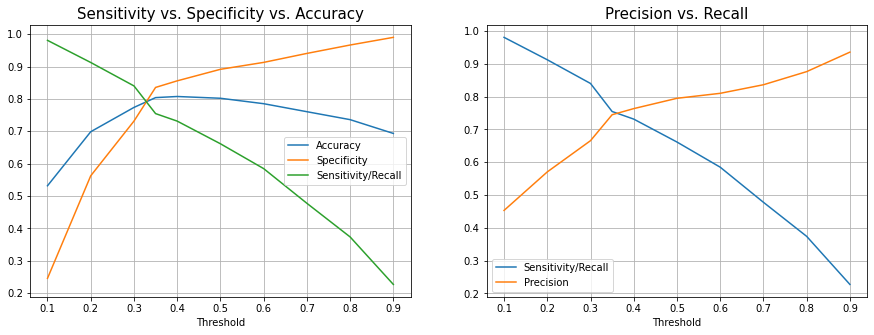

In [88]:
#Temp variable for index
temp = 0

#Dataframe for storing the metrics
pred_metrics = pd.DataFrame(columns=['Threshold','Accuracy','Specificity','Sensitivity/Recall','Precision'])

#Calculating and appending metric values for the below threshold levels
thresh = [0.1,0.2,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9]
for i in thresh:
    cm = confusion_matrix(pred['True_values'], pred[str(i)])
    tn = cm[0,0]
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]

    accuracy = (tp+tn)/(cm.sum())
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)

    pred_metrics.loc[temp] = [i,accuracy,specificity,sensitivity,precision]
    temp = temp+1
    
#Plotting and printing the metric values
fig, ax = plt.subplots(1,2, figsize=(15,5))

#Sensitivity - Specificity - Accuracy
pred_metrics.plot.line(x = 'Threshold', y=['Accuracy','Specificity','Sensitivity/Recall'], grid=True, ax=ax[0])
ax[0].set_title('Sensitivity vs. Specificity vs. Accuracy', fontsize=15)

#Precision - Recall
pred_metrics.plot.line(x = 'Threshold', y=['Sensitivity/Recall','Precision'], grid=True, ax=ax[1])
ax[1].set_title('Precision vs. Recall', fontsize=15)

#Output of the metrics table
pred_metrics

- From the above outputs, we can say that the __optimal cut-off threshold__  lies somewhere between __`0.3` and `0.35`__
- Based on the higher sensitivity in this range, final cut-off (from the plot) will be __`0.32`__

#### ROC

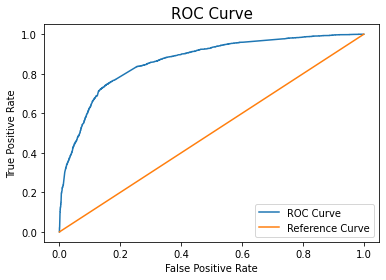

ROC AUC Score: 0.87


In [89]:
#ROC Curve
fpr, tpr, thresholds = roc_curve(pred['True_values'], pred['Predicted_prob'])
plt.plot(fpr,tpr, label='ROC Curve')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1), label='Reference Curve')
plt.title('ROC Curve', fontsize=15)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#ROC AUC Score
print('ROC AUC Score:',round(roc_auc_score(pred['True_values'], pred['Predicted_prob']),2))

We are getting an excellent __ROC AUC Score__ of __`0.87`__

### Getting model scores using optimal threshold

#### Train

In [90]:
#Building a dataframe to check the predicted values, probabilities and evaluate different thresholds
pred_train = pd.DataFrame()

#Ground truth values
pred_train['True_values'] = y_train

#Predicted probabilities
pred_train['Predicted_prob'] = model.predict(X_train_sm)

#Converting to final predictions from probabilities
pred_train['predicted'] = pred_train['Predicted_prob'].apply(lambda x: 1 if x>0.32 else 0)

#Checking the final result
pred_train.head()

,True_values,Predicted_prob,predicted
2736,0,0.123659,0
5577,1,0.868465,1
6904,0,0.116116,0
3585,0,0.116116,0
7044,0,0.066168,0


In [91]:
cm = confusion_matrix(pred_train['True_values'], pred_train['predicted'])
tn = cm[0,0]
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]

train_accuracy = (tp+tn)/(cm.sum())
train_sensitivity = tp/(tp+fn)
train_specificity = tn/(tn+fp)
train_precision = tp/(tp+fp)

#### Test

In [92]:
#Building a dataframe to check the predicted values, probabilities and evaluate different thresholds
pred_test = pd.DataFrame()


X_test_sm = sm.add_constant(X_test[X_train_sm.drop('const',axis=1).columns])

#Ground truth values
pred_test['True_values'] = y_test

#Predicted probabilities
pred_test['Predicted_prob'] = model.predict(X_test_sm)


pred_test['predicted'] = pred_test['Predicted_prob'].apply(lambda x: 1 if x>0.32 else 0)

#Checking the final result
pred_test.head()

,True_values,Predicted_prob,predicted
2151,0,0.062798,0
1476,0,0.274982,0
5277,0,0.321701,1
3866,0,0.116116,0
3185,1,0.882070,1


In [93]:
cm = confusion_matrix(pred_test['True_values'], pred_test['predicted'])
tn = cm[0,0]
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]

test_accuracy = (tp+tn)/(cm.sum())
test_sensitivity = tp/(tp+fn)
test_specificity = tn/(tn+fp)
test_precision = tp/(tp+fp)

#### Comparing scores

,Accuracy,Specificity,Sensitivity/Recall,Precision
Train,0.78,0.75,0.83,0.68
Test,0.77,0.75,0.81,0.66


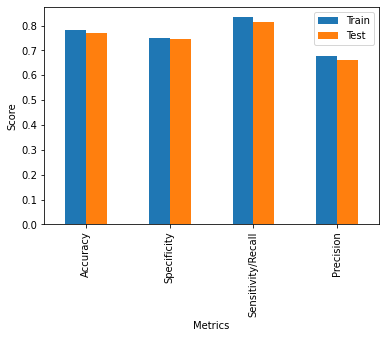

In [94]:
final_scores = pd.DataFrame(columns=['Accuracy','Specificity','Sensitivity/Recall','Precision'])
final_scores.loc['Train'] = [train_accuracy,train_specificity,train_sensitivity,train_precision]
final_scores.loc['Test'] = [test_accuracy,test_specificity,test_sensitivity,test_precision]

final_scores.T.plot(kind='bar')
plt.xlabel('Metrics')
plt.ylabel('Score')
round(final_scores,2)

- Based on the suggestions received by the __CEO__ of __X-Education__, we have the __Sensitivity__ score __`>80%`__ in the final model.


From the above scores, we can say that:


__` If the conversion is NEGATIVE, there's ~20% chance that the model might predict it as POSITIVE`__

## Lead Scores

In [95]:
#Predicting lead scores for all the leads
lead_scores = pd.DataFrame()

#Appending appropriate values
lead_scores['Prospect ID'] = p_id
lead_scores['Lead Number'] = l_num
lead_scores['Lead Score'] = pd.concat([pred_train['Predicted_prob'],pred_test['Predicted_prob']], axis=0)*100
lead_scores['Actual'] = pd.concat([y_train,y_test], axis=0)
lead_scores['Predicted'] = lead_scores['Lead Score'].apply(lambda x: 1 if x>32 else 0)

#Dropping the rows which were dropped during data cleaning
lead_scores=lead_scores.dropna()

#Changing the datatype of 'Actual'
lead_scores['Actual'] = lead_scores['Actual'].astype('int64')

#getting the output
lead_scores.head()

,Prospect ID,Lead Number,Lead Score,Actual,Predicted
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,32.170093,0,1
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,36.388580,0,1
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,73.216763,1,1
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,22.685093,0,0
4,3256f628-e534-4826-9d63-4a8b88782852,660681,71.461333,1,1


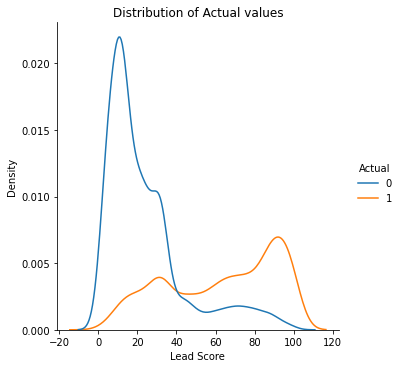

In [96]:
#Checking the distribution of the probability scores accross 'actual' POSITIVE and NEGATIVE classes
sns.displot(data=lead_scores, x='Lead Score', hue='Actual', kind='kde')
plt.title('Distribution of Actual values')
plt.show()

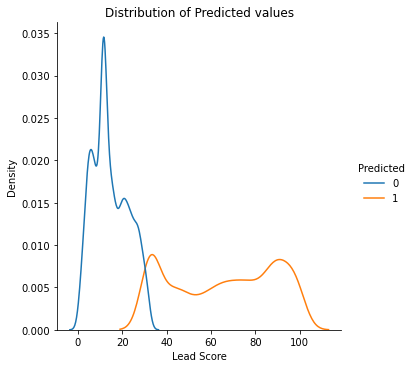

In [97]:
#Checking the distribution of the probability scores accross 'predicted' POSITIVE and NEGATIVE classes
sns.displot(data=lead_scores, x='Lead Score', hue='Predicted', kind='kde')
plt.title('Distribution of Predicted values')
plt.show()

- From the above plots, it is evident from the peaks that the model __is able to GENERALIZE well.__
- While it shows a bigger distribution of __non-converted leads__ than __converted leads__, the pattern seems to be in sync with the imbalance of our original __Target__ variable `Converted`

## Business Recommendations

Now that the model is able to __generalize__ well across all our data, it is important to know the effect of each feature on the target prediction. The features have either __positive__ or __negative__ effect on the `TARGET` variable.

The features with __POSITIVE__ effect are:
   1.	`Lead Source_Google`
   2.	`Lead Source_Organic Search`
   3.	`Lead Source_Olark Chat`
   4.	`Lead Origin_Lead Add Form`
   5.	`Total Time Spent on Website`
   
The features with __NEGATIVE__ effect are:
   1.	`What is your current occupation_Unknown`
   2.	`What is your current occupation_Student`
   3.	`What is your current occupation_Unemployed`
   4.	`Do Not Email`
   5.	`Specialization_Unknown`

<br></br>
Out of all these features, the below features which have the __HIGHEST__ effect on the _Final Prediction_:
1. __`What is your current occupation_Unknown`__
2. __`Lead Origin_Lead Add Form`__
3. __`Total Time Spent on Website`__

The business must be wary of the above features which have the highest implication of whether a lead is `HOT` or `COLD`.